# Inspect viral infection progression

We do this based on MCP and psbA expression derived from channels 4 (TMR) and 11 (Cy5)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load common_.py
from common import *

In [3]:
from ehv import load
from pathlib import Path
import flowkit

In [4]:
df = load.load_raw_ideas_dir(
    Path("/data/weizmann/EhV/high_time_res"), 
    Path("/data/weizmann/EhV/weizmann-ehv-metadata/representations/ideas_features/"), 
    "ALL", 
    Path("/data/weizmann/EhV/weizmann-ehv-metadata/cell_populations/manual_gating/"))

df = load.remove_unwanted_features(df)
df = load.tag_columns(df)

In [5]:
df.shape

(2352327, 127)

In [6]:
df = df[df["meta_label_COI"] == True]

In [13]:
feat_cols = df.filter(regex=".*feat.*").columns
for (t_idx, r_idx), gdf in df.groupby(["meta_timepoint", "meta_replicate"]):
    col_mins = gdf[feat_cols].quantile(0.01)
    col_maxs = gdf[feat_cols].quantile(0.99)
    
    df.loc[
        (df["meta_timepoint"] == t_idx) & (df["meta_replicate"] == r_idx),
        feat_cols
    ] = (gdf[feat_cols] - col_mins) / (col_maxs - col_mins)

In [22]:
xform = flowkit.transforms.LogicleTransform('logicle', param_t=10000, param_w=0.5, param_m=4.5, param_a=0)
samples = []
for (t_idx, r_idx), gdf in df[df["meta_group"] == "High"].groupby(["meta_timepoint", "meta_replicate"]):
    sample = flowkit.Sample(gdf[["feat_Intensity_MC_Ch04", "feat_Intensity_MC_Ch11", "feat_Intensity_MC_Ch7"]])
    sample.apply_transform(xform)
    sample_df = sample.as_dataframe(source="xform").set_index(gdf.index)
    sample_df.columns = sample_df.columns.get_level_values(0)
    sample_df = pandas.concat([sample_df, gdf.filter(regex="meta_.*")], axis=1)
    samples.append(sample_df)

df_logicle = pandas.concat(samples)

(-2.005942262710321, 6.131139465069176, -1.595582758535039, 17.95665476237644)

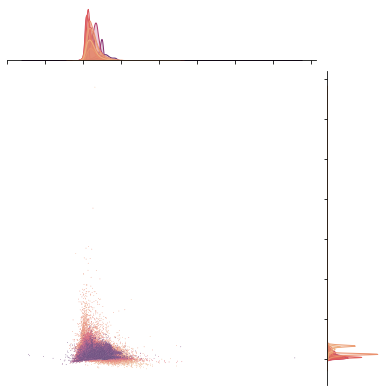

In [23]:
fig = seaborn.jointplot(
    data=df_logicle, y="feat_Intensity_MC_Ch04", x="feat_Intensity_MC_Ch11", 
    hue="meta_timepoint", hue_order=df_logicle["meta_timepoint"].unique(), 
    s=0.5, palette="flare", legend=False)
# fig.ax_joint.legend(bbox_to_anchor=(1.22, 1), loc=2, borderaxespad=0.)
fig.ax_joint.axis("off")
# plt.savefig("figs/features/HTR_High_viral_progression.png", dpi=300, transparent=True, bbox_inches = "tight")